In [109]:
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import re
from nltk.corpus import stopwords
import string
from tqdm import tqdm
from scipy.sparse import csr_matrix
import tensorflow as tf
import keras
from keras.layers import Dense, Embedding, Bidirectional, Input
from keras.models import Model
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
stop_words = stopwords.words('indonesian')

In [110]:
df = pd.read_csv('text.csv')
df

,text
0,izone adalah wifi
1,byod adalah wifi
2,dzone adalah wifi
3,login ke vpn perlu ibm
4,login ke visa perlu microsoft remote desktop
5,wifi bisa digunakan untuk connect ke intranet
6,visa digunakan untuk terhubung intranet
7,visa adalah remote desktop
8,izone adalah wifi yang digunakan untuk terhubu...
9,konek ke wifi izone


In [111]:
texts = [x for x in df['text']]

In [112]:
def text_preprocessing(text, punctuations = r'''!()-[]{};:'"\,<>./?@#$%^&*_“~'''):
    stemm_factory = StemmerFactory()
    stemm = stemm_factory.create_stemmer()
    for x in text.lower(): 
        if x in punctuations: 
            text = text.replace(x, "")
    text = stemm.stem(text)
    # Removing words that have numbers in them
    text = re.sub(r'\w*\d\w*', '', text)

    # Removing digits
    text = re.sub(r'[0-9]+', '', text)

    # Cleaning the whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Setting every word to lower
    text = text.lower()

    # Converting all our text to a list 
    text = text.split(' ')

    # Droping empty strings
    text = [x for x in text if x!='']

    # Droping stop words
    text = [x for x in text if x not in stop_words]

    return text

In [113]:
window = 2
word_lists = []
all_text = []

for text in texts:

    # Cleaning the text
    text = text_preprocessing(text)

    # Appending to the all text list
    all_text += text 

    # Creating a context dictionary
    for i, word in enumerate(text):
        for w in range(window):
            # Getting the context that is ahead by *window* words
            if i + 1 + w < len(text): 
                word_lists.append([word] + [text[(i + 1 + w)]])
            # Getting the context that is behind by *window* words    
            if i - w - 1 >= 0:
                word_lists.append([word] + [text[(i - w - 1)]])

In [114]:
word_lists

[['izone', 'wifi'],
 ['wifi', 'izone'],
 ['byod', 'wifi'],
 ['wifi', 'byod'],
 ['dzone', 'wifi'],
 ['wifi', 'dzone'],
 ['login', 'vpn'],
 ['login', 'ibm'],
 ['vpn', 'ibm'],
 ['vpn', 'login'],
 ['ibm', 'vpn'],
 ['ibm', 'login'],
 ['login', 'visa'],
 ['login', 'microsoft'],
 ['visa', 'microsoft'],
 ['visa', 'login'],
 ['visa', 'remote'],
 ['microsoft', 'remote'],
 ['microsoft', 'visa'],
 ['microsoft', 'desktop'],
 ['microsoft', 'login'],
 ['remote', 'desktop'],
 ['remote', 'microsoft'],
 ['remote', 'visa'],
 ['desktop', 'remote'],
 ['desktop', 'microsoft'],
 ['wifi', 'connect'],
 ['wifi', 'intranet'],
 ['connect', 'intranet'],
 ['connect', 'wifi'],
 ['intranet', 'connect'],
 ['intranet', 'wifi'],
 ['visa', 'hubung'],
 ['visa', 'intranet'],
 ['hubung', 'intranet'],
 ['hubung', 'visa'],
 ['intranet', 'hubung'],
 ['intranet', 'visa'],
 ['visa', 'remote'],
 ['visa', 'desktop'],
 ['remote', 'desktop'],
 ['remote', 'visa'],
 ['desktop', 'remote'],
 ['desktop', 'visa'],
 ['izone', 'wifi'],
 ['i

In [115]:
def create_unique_word_dict(text:list) -> dict:
    """
    A method that creates a dictionary where the keys are unique words
    and key values are indices
    """
    # Getting all the unique words from our text and sorting them alphabetically
    words = list(set(text))
    words.sort()

    # Creating the dictionary for the unique words
    unique_word_dict = {}
    for i, word in enumerate(words):
        unique_word_dict.update({
            word: i
        })

    return unique_word_dict   

In [116]:
unique_word = create_unique_word_dict(all_text)
n_words = len(unique_word)
words = list(unique_word)

In [117]:
X = []
Y = []
for i, word_list in tqdm(enumerate(word_lists)):
    # Getting the indices
    main_word_index = unique_word.get(word_list[0])
    context_word_index = unique_word.get(word_list[1])

    X_row = np.zeros(n_words)
    Y_row = np.zeros(n_words)

    X_row[main_word_index] = 1

    Y_row[context_word_index] = 1


    X.append(X_row)
    Y.append(Y_row)

X = csr_matrix(X).toarray()
Y = csr_matrix(Y).toarray()

embed_size = 50
inp = Input(shape=(X.shape[1],))
x = Dense(units=embed_size, activation='linear')(inp)
x = Dense(units=Y.shape[1], activation='softmax')(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

392it [00:00, 61189.70it/s]


In [118]:
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 63)]              0         
                                                                 
 dense_14 (Dense)            (None, 50)                3200      
                                                                 
 dense_15 (Dense)            (None, 63)                3213      
                                                                 
Total params: 6,413
Trainable params: 6,413
Non-trainable params: 0
_________________________________________________________________


In [119]:
model.fit(
    x=X, 
    y=Y, 
    batch_size=256,
    epochs=1000
)

Epoch 1/1000
2/2 [==============================] - 1s 9ms/step - loss: 4.1506
Epoch 2/1000
2/2 [==============================] - 0s 7ms/step - loss: 4.1393
Epoch 3/1000
2/2 [==============================] - 0s 4ms/step - loss: 4.1289
Epoch 4/1000
2/2 [==============================] - 0s 6ms/step - loss: 4.1187
Epoch 5/1000
2/2 [==============================] - 0s 5ms/step - loss: 4.1086
Epoch 6/1000
2/2 [==============================] - 0s 8ms/step - loss: 4.0986
Epoch 7/1000
2/2 [==============================] - 0s 4ms/step - loss: 4.0887
Epoch 8/1000
2/2 [==============================] - 0s 4ms/step - loss: 4.0786
Epoch 9/1000
2/2 [==============================] - 0s 7ms/step - loss: 4.0686
Epoch 10/1000
2/2 [==============================] - 0s 4ms/step - loss: 4.0586
Epoch 11/1000
2/2 [==============================] - 0s 4ms/step - loss: 4.0487
Epoch 12/1000
2/2 [==============================] - 0s 7ms/step - loss: 4.0385
Epoch 13/1000
2/2 [==============================

In [ ]:
weights = model.get_weights()[0]

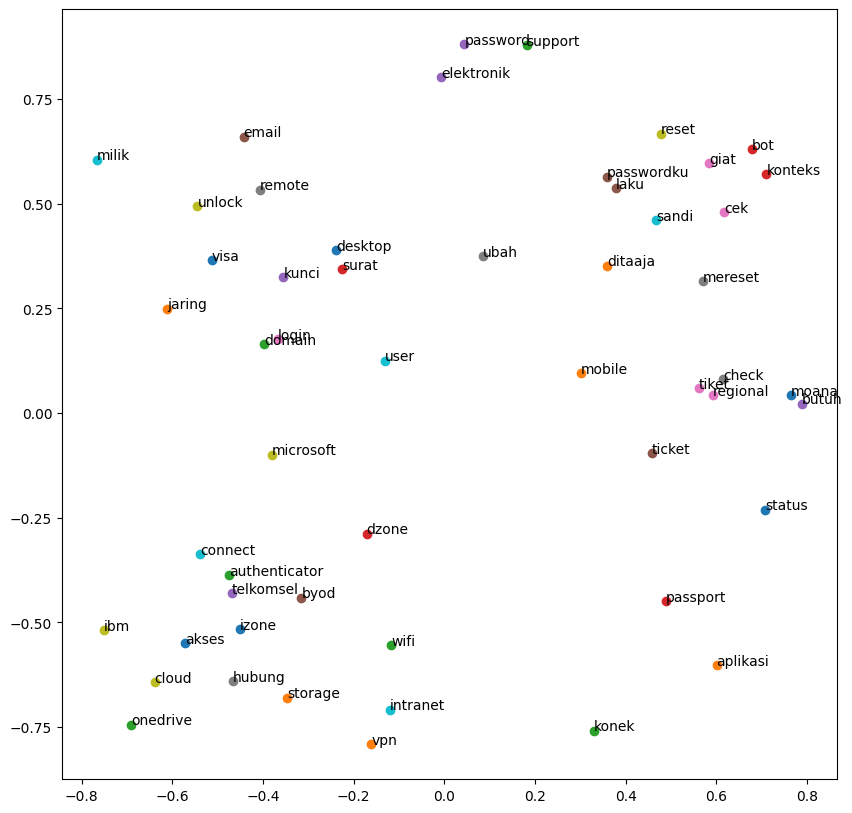

In [ ]:
import matplotlib.pyplot as plt
embedding_dict = {}
for word in words: 
    embedding_dict.update({
        word: weights[unique_word.get(word)]
        })

# Ploting the embeddings
plt.figure(figsize=(10, 10))
for word in list(unique_word.keys()):
    coord = embedding_dict.get(word)
    plt.scatter(coord[0], coord[1])
    plt.annotate(word, (coord[0], coord[1]))    

In [ ]:
with open('embedding.txt', 'w+') as file:
    for key, value in embedding_dict.items():
        # string_value = value
        real_value = " ".join([" {}".format(s).strip() for s in value])
        # for i, s in enumerate(string_value):
        #     if i == 0:
        #         real_value = "{}".format(s)
        #     else:
        #         real_value += " {}".format(s)
        file.write(f'{key}, {real_value}\n')

In [ ]:
def euclidean(vec1:np.array, vec2:np.array) -> float:
    """
    A function to calculate the euclidean distance between two vectors
    """
    return np.sqrt(np.sum((vec1 - vec2)**2))


def find_similar(word:str, embedding_dict:dict, top_n=10)->list:
    """
    A method to find the most similar word based on the learnt embeddings
    """
    dist_dict = {}
    word_vector = embedding_dict.get(word, [])
    if len(word_vector) > 0:
        for key, value in embedding_dict.items():
            if key!=word:
                dist = euclidean(word_vector, value)
                dist_dict.update({
                    key: dist
                })

        return sorted(dist_dict.items(), key=lambda x: x[1])[0:top_n]  
    

find_similar('ubah', embedding_dict)

[('giat', 1.2384686),
 ('passwordku', 2.1614199),
 ('sandi', 2.6642478),
 ('moana', 3.0566692),
 ('reset', 3.329117),
 ('ubah', 3.4808211),
 ('laku', 3.4982865),
 ('password', 3.5115592),
 ('mereset', 3.641025),
 ('bot', 3.9582295)]